# Predicting weather given available ground observations

### Notes on the Dataset
* Weather observation data from the UK Met Office Datapoint service
* Ground observations are made hourly at weather stations across the length of the UK 
* The data sample covers data from June 2019
* Data collections for each day starts at 6.30pm. All observation data is listed in one day blocks
* The time value column refers to the number of minutes after midnight 

## Preamble

In [74]:
# Imports
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.inspection import PartialDependenceDisplay
%matplotlib inline

# Suppress unnecessary ConvergenceWarnings and DeprecationWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Set a random seed variable to make results more reproducible
seed = 5
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

# Switch off multi-threading for TensorFlow
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
K.set_session(sess)

In [75]:
# Load in the prepared weather data
obs = pd.read_csv('weather.csv')
obs.head()

,StationID,StationName,Elevation,Latitude,Longitude,Date,Time,Gust,Temperature,Visibility,WindDirection,WindSpeed,Pressure,PressureTrend,DewPoint,Humidity,Type
0,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1020,NaN,16.1,30000.0,E,8.0,1019.0,F,11.6,74.5,0
1,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1080,NaN,14.9,22000.0,E,8.0,1019.0,F,11.8,81.5,0
2,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1140,NaN,14.0,14000.0,E,6.0,1018.0,F,11.6,85.4,0
3,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1200,NaN,12.9,12000.0,ENE,2.0,1019.0,R,11.0,88.1,0
4,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1260,NaN,12.0,9000.0,E,2.0,1019.0,R,10.9,92.9,1


In [76]:
obs.shape

(106553, 17)

In [77]:
obs.describe()

,StationID,Elevation,Latitude,Longitude,Time,Gust,Temperature,Visibility,WindSpeed,Pressure,DewPoint,Humidity,Type
count,106553.000000,106553.000000,106553.000000,106553.000000,106553.000000,7703.000000,106442.000000,92662.000000,102060.000000,99530.000000,106402.000000,106397.000000,106553.00000
mean,6147.845636,114.466594,53.673022,-2.829034,702.914418,33.043749,14.958912,25698.164404,8.999510,1018.748337,10.348008,76.185240,0.99603
std,15821.503845,171.669120,2.466079,2.269594,412.057262,13.424855,4.294516,14263.873943,6.087882,6.327468,3.120565,17.208653,0.92971
min,3002.000000,2.000000,49.207900,-10.250000,0.000000,0.000000,-1.200000,20.000000,0.000000,976.000000,-28.200000,0.800000,0.00000
25%,3204.000000,20.000000,51.565000,-4.149000,360.000000,29.000000,12.000000,14000.000000,5.000000,1015.000000,8.400000,65.300000,0.00000
50%,3414.000000,65.000000,53.175000,-2.663000,720.000000,32.000000,14.500000,25000.000000,8.000000,1018.000000,10.500000,79.200000,1.00000
75%,3769.000000,132.000000,55.285000,-1.097000,1020.000000,39.000000,17.500000,35000.000000,11.000000,1024.000000,12.500000,90.000000,1.00000
max,99142.000000,1245.000000,60.749000,1.348000,1380.000000,105.000000,31.600000,75000.000000,81.000000,1036.000000,22.700000,100.000000,3.00000


### Will use 8 input features to classify the weather type: one of three options (clear, cloudy, or raining)

In [78]:
# Define 8 input feature variables, 1 target variable data, and names of the 3 weather types
features = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity', 'WindDirection']
output   = ['Type']
wtype    = ['Clear', 'Cloudy', 'Precip']

Define derived dataset containing only the relevant columns and rows.

In [79]:
# Reduce to feature and type columns
dataset = obs[features + output]

# Drop duplicates and null values 
dataset = dataset.drop_duplicates().dropna()

# Drop unrecorded weather type
dataset = dataset[dataset.Type != 3]

# Check shape 
dataset.shape

(86313, 9)

In [80]:
dataset.head(10)

,Latitude,Elevation,Temperature,Visibility,WindSpeed,Pressure,Humidity,WindDirection,Type
0,60.749,15.0,16.1,30000.0,8.0,1019.0,74.5,E,0
1,60.749,15.0,14.9,22000.0,8.0,1019.0,81.5,E,0
2,60.749,15.0,14.0,14000.0,6.0,1018.0,85.4,E,0
3,60.749,15.0,12.9,12000.0,2.0,1019.0,88.1,ENE,0
4,60.749,15.0,12.0,9000.0,2.0,1019.0,92.9,E,1
5,60.749,15.0,11.3,8000.0,1.0,1019.0,94.8,E,1
6,60.749,15.0,11.1,7000.0,5.0,1019.0,97.4,E,1
7,60.749,15.0,10.0,4700.0,0.0,1019.0,96.7,N,1
8,60.749,15.0,10.6,6000.0,0.0,1019.0,98.7,N,1
9,60.749,15.0,11.2,100.0,0.0,1019.0,99.3,N,1


## Data preprocessing

In [81]:
# import(s)
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

- Need to One-hot encode the Wind direction feature i.e. convert string 'NNE' to integer values so that can the dataframe can be inputted to the neural network/ decision tree

In [82]:
#For convenience concatenate the wind direction and other features 
# in the order that you can use this feature name variable
feature_names = list(range(16)) + features[:-1]
print(feature_names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity']


In [83]:
#Group by type of weather (target) and randomly sample 3500 per type
sample = dataset.groupby(['Type']).sample(n = 3500)

#Create target aray into numpy
y = sample[output].values.flatten()

#Onehotencode wind direction column
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), ['WindDirection'])], remainder='passthrough')

#Onehotencode wind direction but passthrough other features into numpy array
X = columnTransformer.fit_transform(sample[features])
#convert output data into array
y = sample[output].values.flatten()

#check shapes
print (X.shape)
print (y.shape)

(10500, 23)
(10500,)


## Random forest in `scikit-learn`

In [84]:
#Import random forest and confusion matrix metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

(7350, 23) (3150, 23) (7350,)


In [85]:
# We scan a broad range of parameters to use for the RandomForest
rf_dic={
    "n_estimators":[10,50,200,500],
    "max_features": ["sqrt","log2"],
    "criterion": ["gini"],
    "max_depth": [4,8,30]
    }

In [86]:
#Grid search object containing random forest classifier to search for optimum parameters to train the random forest 
grid_search = GridSearchCV(RandomForestClassifier(random_state = 1), rf_dic, n_jobs = 7, cv = 3)


In [87]:
#Fit the RF
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=7,
             param_grid={'criterion': ['gini'], 'max_depth': [4, 8, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 200, 500]})

In [88]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=500, random_state=1)

In [89]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [90]:
#Print both training and testing accuracy 
print("Overall accuracy training: {:.1f}%".format(grid_search.score(x_train, y_train)*100))
print("Overall accuracy testing: {:.1f}%".format(grid_search.score(x_test, y_test)*100))

Overall accuracy training: 100.0%
Overall accuracy testing: 74.3%


---

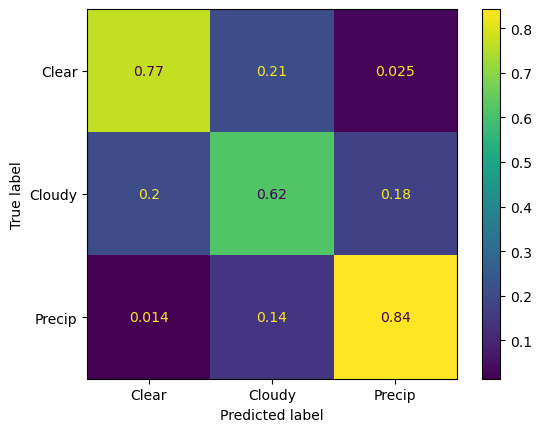

In [91]:
#Plot the confusion matrix to understand a bit more about the classification accuracy 
#Values normalised over true labels (rows add to 1) 

cm = confusion_matrix(y_test, grid_search.predict(x_test), normalize = 'true')

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Clear', 'Cloudy', 'Precip'])
disp.plot()

plt.show()

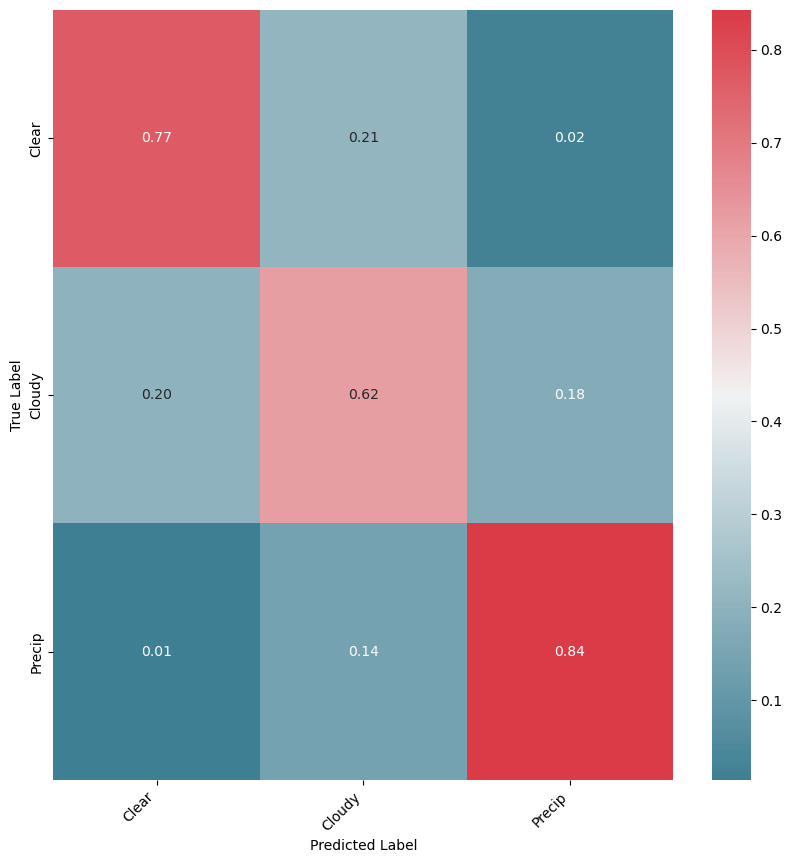

In [92]:
# Use the following colourmap in as the cmap parameter of sns.heatmap:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10))

# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(cm , cmap=colormap, annot=True, fmt=".2f")
ax.set_xticklabels(
    wtype,
    rotation=45,
    horizontalalignment='right')

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_yticklabels(wtype)
plt.show();

- Diagonal much higher than off diagonal therefore quite succesful at predicting weather correctly. 
- Understandably cloudy harder to predict as other weather features likely to be similar to both sunny and rainy weather  

------------------
#### Plot training feature importance for random forest

Quantifies how much each feature splits the dataset 

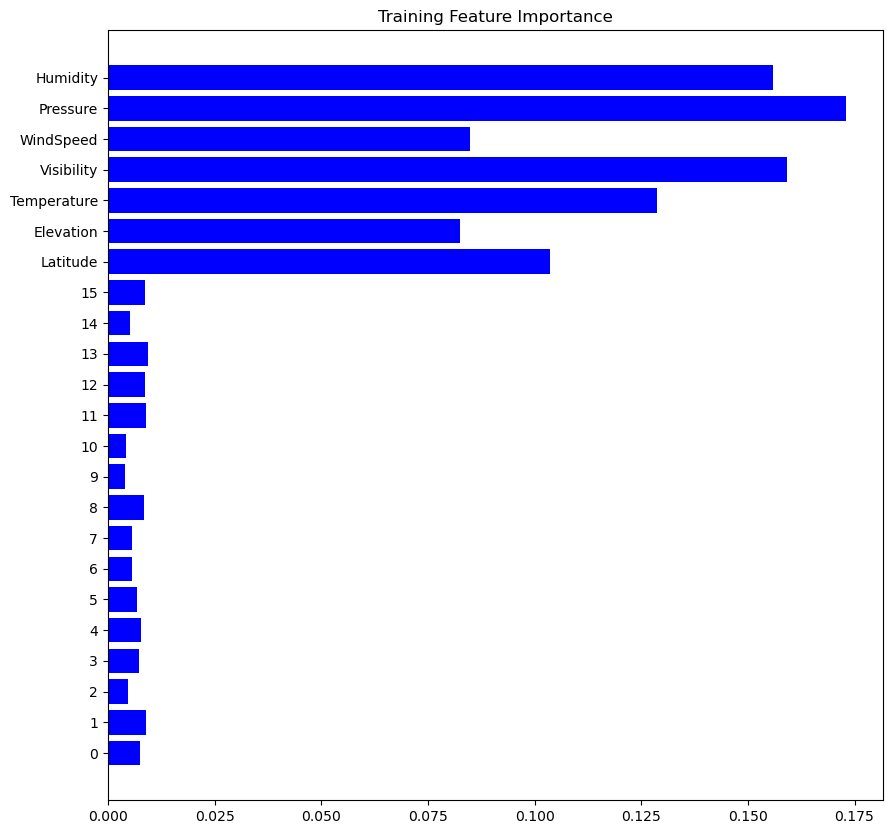

In [93]:
# Given plotting example for feature importance
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(range(23), grid_search.best_estimator_.feature_importances_, color = 'blue')
ax.set_yticks(range(23),feature_names)
ax.set_title("Training Feature Importance")
plt.show()

- 'Feature_importance_' calculated and biased towards training dataset therefore may not represent most relevant features of testing dataset
- Can use 'permutation_importance' as it shuffles features one at a time and looks at how accuracy changes 

In [94]:
from sklearn.inspection import permutation_importance

In [95]:
result = permutation_importance(grid_search, x_test, y_test, n_repeats = 20, random_state = 42, n_jobs = -1)

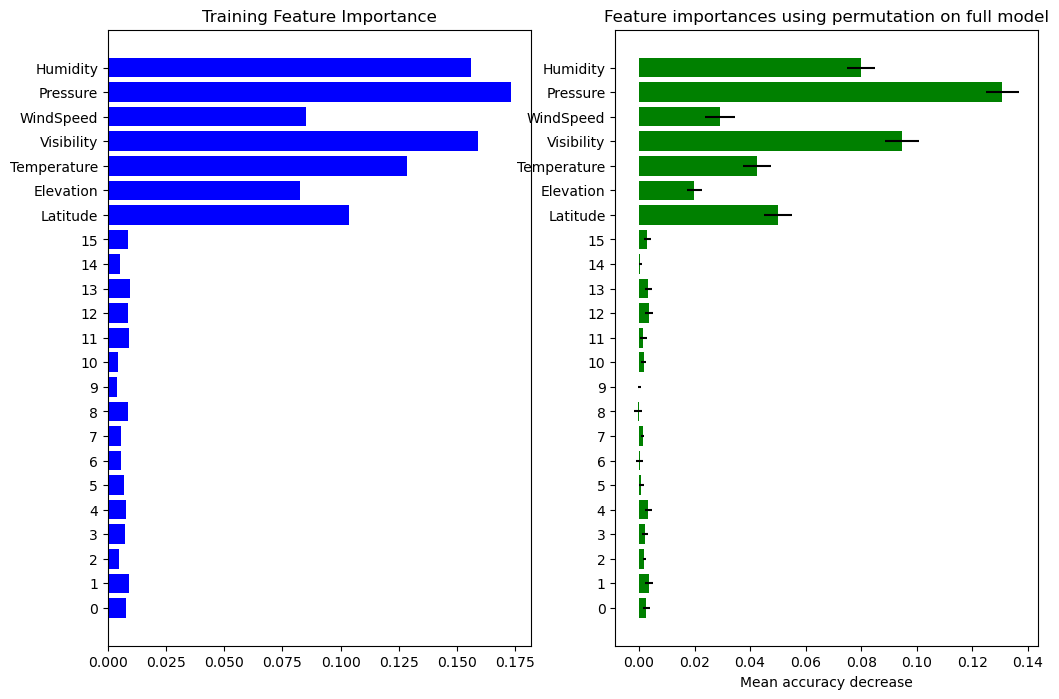

In [96]:
#Plot both plots allongside to compare differences in relevant features for training & testing

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(range(23), grid_search.best_estimator_.feature_importances_, color = 'blue')
ax1.set_yticks(range(23),feature_names)
ax1.set_title("Training Feature Importance")


ax2.barh(range(23), result.importances_mean,xerr=result.importances_std, color = 'green')
ax2.set_yticks(range(23),feature_names)
ax2.set_title("Feature importances using permutation on full model")
ax2.set_xlabel("Mean accuracy decrease")
plt.show()
fig.tight_layout()
plt.show()

Using PartialDependenceDisplay can choose some features that can vary within a range, while other fixed. Can look at how probability estimate changes on average

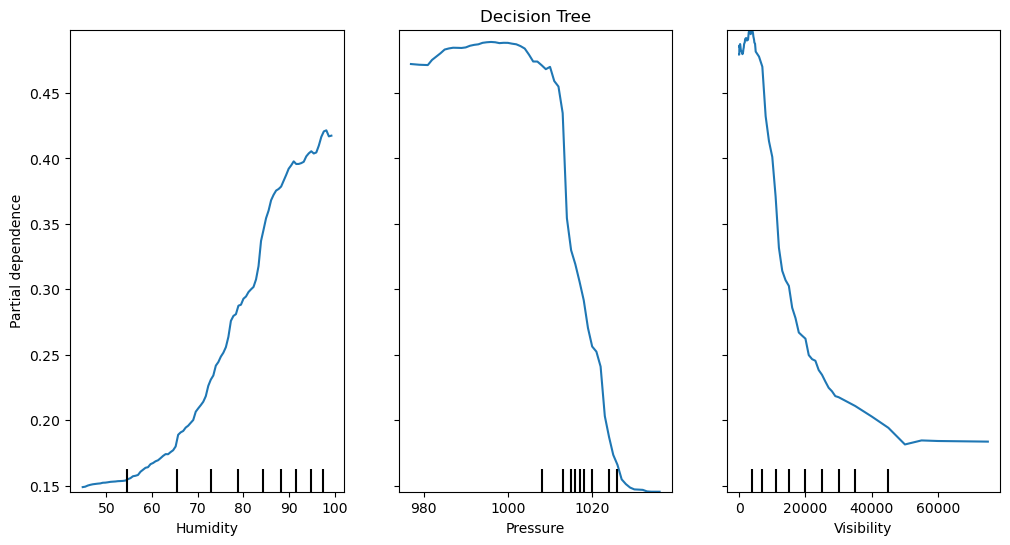

In [97]:
#Target [2] corresponds to chance of rain
#Seeing change in probability of rain by varying humidity, pressure, and visibility

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Decision Tree")
tree_disp = PartialDependenceDisplay.from_estimator(grid_search, x_test, features = [22, 21, 19], target = [2], ax = ax, feature_names = feature_names)


Three most dominant features (from previous plots) show correlation to chance of rain i.e. higher humidity, lower pressure and visibility mean higher chance of rain

## Neural network in `scikit-learn`

In [98]:
#Import neural network
from sklearn.neural_network import MLPClassifier


- Use standardscalar to to normalised all columns except wind direction (as already standardised from 0 to 1) to have means of 0 and s.d. of 1 

In [99]:
#standardise all columns except wind direction
scalar = StandardScaler()

#ignore first 16 wind direction columns
X_cut = X[:, 16:]

z = scalar.fit_transform(X_cut)

X[:, 16:] = z



In [100]:
# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

(7350, 23) (3150, 23) (7350,)


Construct and train neural network with 1 hidden layer of 50 neurons, train for 100 epochs, batch size 32

In [101]:
#verbose = True to view the epochs
NN_sk = MLPClassifier( hidden_layer_sizes = [50], max_iter = 100, batch_size = 32, verbose = True ).fit(x_train, y_train)

Iteration 1, loss = 0.85243904
Iteration 2, loss = 0.71854453
Iteration 3, loss = 0.69219394
Iteration 4, loss = 0.67987399
Iteration 5, loss = 0.67239713
Iteration 6, loss = 0.66715163
Iteration 7, loss = 0.66148918
Iteration 8, loss = 0.65805100
Iteration 9, loss = 0.65429208
Iteration 10, loss = 0.65100118
Iteration 11, loss = 0.64849390
Iteration 12, loss = 0.64677220
Iteration 13, loss = 0.64367676
Iteration 14, loss = 0.64214106
Iteration 15, loss = 0.63927340
Iteration 16, loss = 0.63766858
Iteration 17, loss = 0.63660001
Iteration 18, loss = 0.63451507
Iteration 19, loss = 0.63282299
Iteration 20, loss = 0.63195837
Iteration 21, loss = 0.62982623
Iteration 22, loss = 0.62884832
Iteration 23, loss = 0.62748082
Iteration 24, loss = 0.62596371
Iteration 25, loss = 0.62473385
Iteration 26, loss = 0.62384720
Iteration 27, loss = 0.62217182
Iteration 28, loss = 0.62099487
Iteration 29, loss = 0.62003007
Iteration 30, loss = 0.62018036
Iteration 31, loss = 0.61758570
Iteration 32, los

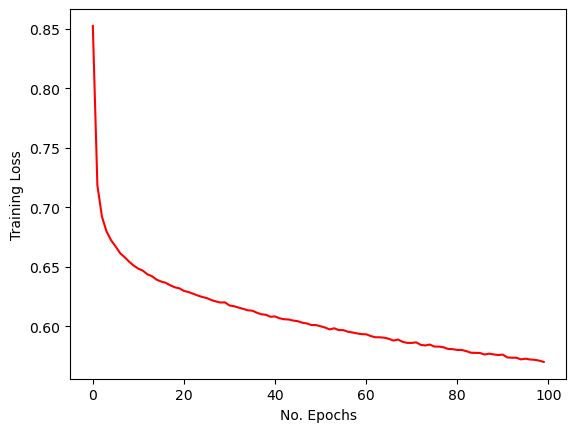

In [102]:
#Plot the training loss (sklearn doesn't offer a validation loss curve)

plt.plot(NN_sk.loss_curve_, color = 'red')
plt.xlabel('No. Epochs')
plt.ylabel('Training Loss');

In [103]:
print ('Overall train accuracy {:.1f}%'.format(NN_sk.score(x_train, y_train)*100))
print ('Overall test accuracy {:.1f}%'.format(NN_sk.score(x_test, y_test)*100))

Overall train accuracy 75.4%
Overall test accuracy 70.0%


In [104]:
ypred = NN_sk.predict(x_test)
cm = confusion_matrix(y_test, ypred, normalize = 'true')

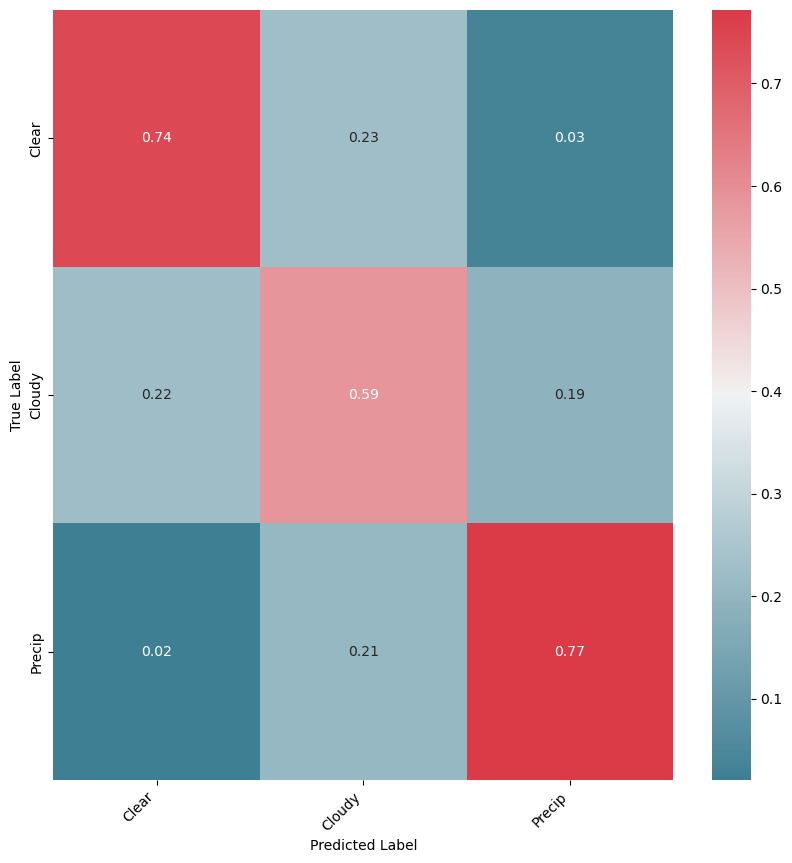

In [105]:
# Use the following courmap in as the cmap parameter of sns.heatmap:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10))
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(cm , cmap=colormap, annot=True, fmt=".2f")
ax.set_xticklabels(
    wtype,
    rotation=45,
    horizontalalignment='right'
);
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_yticklabels(wtype);
plt.show()

70% accuracy seems better than guessing (33%) so seems reasonable. Higher numbers along diagonal but again harder to distinguish between cloudy and rainy and cloudy and clear than distinguish between clear and rainy, similar to the random forest, which makes sense

## Neural network in `Keras` 


In [106]:
# Relevant import(s) for this section
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense
import keras

Construct NN using Keras API:
- input 23 nodes (same # as features)
- Hidden layer 50 nodes
- Ouput 3 nodes (so chance for rainy, cloudy, or clear)

In [107]:
inputs = Input(shape = x_train.shape[1])
dense = Dense(50, activation = 'relu')
x = dense(inputs)
outputs = Dense(3, activation = 'softmax')(x)

model = Model(inputs = inputs, outputs = outputs, name = 'weather_model')
model.summary()

Model: "weather_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                1200      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 153       
Total params: 1,353
Trainable params: 1,353
Non-trainable params: 0
_________________________________________________________________


In [108]:
#sparecategoricalcrossentropy as using integer-valued targets

loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = 'Adam', 
              loss = loss_fn,
              metrics = ['accuracy'])

Train 100 epochs, batch size 32, and keep 20% data for validation, and shuffle = True which shuffles training data between epochs

In [109]:
history_mdl = model.fit(x = x_train, y = y_train, epochs = 100, batch_size = 32, validation_split = 0.2, shuffle = True)

Epoch 1/100
184/184 [==============================] - 3s 6ms/step - loss: 0.8714 - accuracy: 0.5796 - val_loss: 0.7270 - val_accuracy: 0.6782
Epoch 2/100
184/184 [==============================] - 1s 4ms/step - loss: 0.7377 - accuracy: 0.6578 - val_loss: 0.6802 - val_accuracy: 0.6980
Epoch 3/100
184/184 [==============================] - 1s 4ms/step - loss: 0.7116 - accuracy: 0.6675 - val_loss: 0.6704 - val_accuracy: 0.7041
Epoch 4/100
184/184 [==============================] - 1s 4ms/step - loss: 0.6986 - accuracy: 0.6753 - val_loss: 0.6615 - val_accuracy: 0.7034
Epoch 5/100
184/184 [==============================] - 1s 4ms/step - loss: 0.6892 - accuracy: 0.6827 - val_loss: 0.6595 - val_accuracy: 0.7041
Epoch 6/100
184/184 [==============================] - 1s 4ms/step - loss: 0.6822 - accuracy: 0.6852 - val_loss: 0.6561 - val_accuracy: 0.7007
Epoch 7/100
184/184 [==============================] - 1s 3ms/step - loss: 0.6767 - accuracy: 0.6879 - val_loss: 0.6558 - val_accuracy: 0.7034

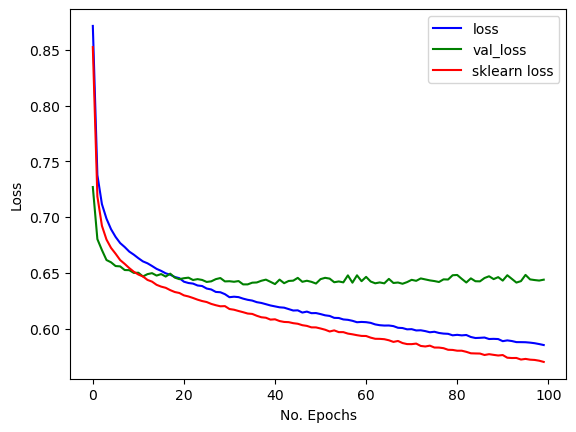

In [110]:
#Plot loss and validation loss and compare with sklearn NN

plt.plot(history_mdl.history['loss'], label = 'loss', color = 'blue')
plt.plot(history_mdl.history['val_loss'], label = 'val_loss', color = 'green')
plt.plot(NN_sk.loss_curve_, color = 'red', label = 'sklearn loss')

plt.legend()
plt.xlabel('No. Epochs')
plt.ylabel('Loss');

Both Keras and Sklearn similar (same structure) and seems to be a bit of overtraining

In [111]:
print ('Train accuracy {:.1f}%'.format(model.evaluate(x_train, y_train)[1]*100))
print ('Test accuracy {:.1f}%'.format(model.evaluate(x_test, y_test)[1]*100))

230/230 [==============================] - 1s 3ms/step - loss: 0.5918 - accuracy: 0.7374
Train accuracy 73.7%
99/99 [==============================] - 0s 2ms/step - loss: 0.6757 - accuracy: 0.6962
Test accuracy 69.6%


In [112]:
#Compare to sklearn 

print ('Overall train accuracy {:.1f}%'.format(NN_sk.score(x_train, y_train)*100))
print ('Overall test accuracy {:.1f}%'.format(NN_sk.score(x_test, y_test)*100))


Overall train accuracy 75.4%
Overall test accuracy 70.0%


## Using regularisation terms

Regularisation term added to cost function to try and avoid overfitting

In [113]:
# More imports
from tensorflow.python.keras.regularizers import l1_l2

Make a function that makes a 2 hidden layer deep NN each with 100 nodes. Function takes in two regularisation terms 

In [114]:
def big_model_fn(l1=0, l2=0, name=None ):

    regulizer = l1_l2(l1=l1, l2=l2)

    inputs = Input(shape = (23,))
    dense1 = Dense(100, activation = 'relu', kernel_regularizer = regulizer)(inputs)
    dense2 = Dense(100, activation = 'relu', kernel_regularizer = regulizer)(dense1)
    outputs = Dense(3, activation = 'softmax')(dense2)

    model = Model(inputs = inputs, outputs = outputs, name = name)
    model.compile(optimizer = 'Adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
    
    return model 
    

Three new models, one bigger model with no regularisation, and one with one L1 regularisation term, another with an L2 regularisation term 

In [115]:
big_mdl    = big_model_fn()
big_mdl_L1 = big_model_fn(l1=0.003, name='model_L1')
big_mdl_L2 = big_model_fn(l2=0.03,  name='model_L2')

In [116]:
#Fit models

history_big_mdl    = big_mdl.fit(x = x_train, y = y_train, epochs = 100, batch_size = 32, validation_split = 0.2, shuffle = True)
history_big_mdl_L1 = big_mdl_L1.fit(x = x_train, y = y_train, epochs = 100, batch_size = 32, validation_split = 0.2, shuffle = True)
history_big_mdl_L2 = big_mdl_L2.fit(x = x_train, y = y_train, epochs = 100, batch_size = 32, validation_split = 0.2, shuffle = True)

Epoch 1/100
184/184 [==============================] - 2s 6ms/step - loss: 0.7778 - accuracy: 0.6321 - val_loss: 0.6740 - val_accuracy: 0.6980
Epoch 2/100
184/184 [==============================] - 1s 5ms/step - loss: 0.6904 - accuracy: 0.6832 - val_loss: 0.6572 - val_accuracy: 0.7129
Epoch 3/100
184/184 [==============================] - 1s 5ms/step - loss: 0.6716 - accuracy: 0.6889 - val_loss: 0.6470 - val_accuracy: 0.7150
Epoch 4/100
184/184 [==============================] - 1s 4ms/step - loss: 0.6611 - accuracy: 0.7003 - val_loss: 0.6433 - val_accuracy: 0.7088
Epoch 5/100
184/184 [==============================] - 1s 4ms/step - loss: 0.6493 - accuracy: 0.7048 - val_loss: 0.6462 - val_accuracy: 0.7095
Epoch 6/100
184/184 [==============================] - 1s 5ms/step - loss: 0.6422 - accuracy: 0.7060 - val_loss: 0.6401 - val_accuracy: 0.7177
Epoch 7/100
184/184 [==============================] - 1s 5ms/step - loss: 0.6329 - accuracy: 0.7150 - val_loss: 0.6399 - val_accuracy: 0.7136

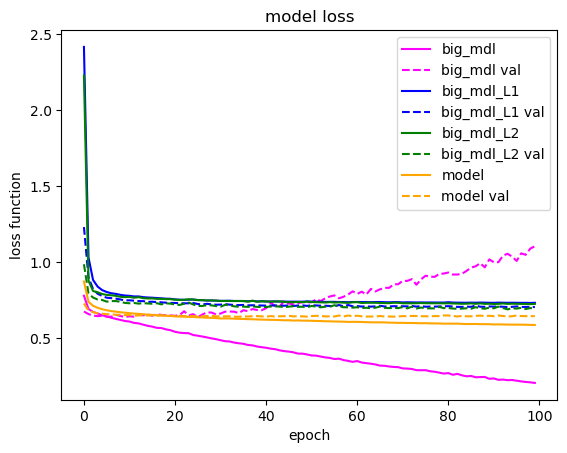

In [117]:
# big model vs smaller model
cols = ["magenta","blue","green","orange"]
labels = ['big_mdl','big_mdl_L1','big_mdl_L2', 'model']
for i,mod in enumerate([history_big_mdl, history_big_mdl_L1, history_big_mdl_L2, history_mdl]):
    plt.plot(mod.history["loss"], color=cols[i], label=labels[i])
    plt.plot(mod.history["val_loss"], color=cols[i], label= "{} val".format(labels[i]), linestyle = 'dashed')
plt.title('model loss')
plt.ylabel('loss function')
plt.xlabel('epoch')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

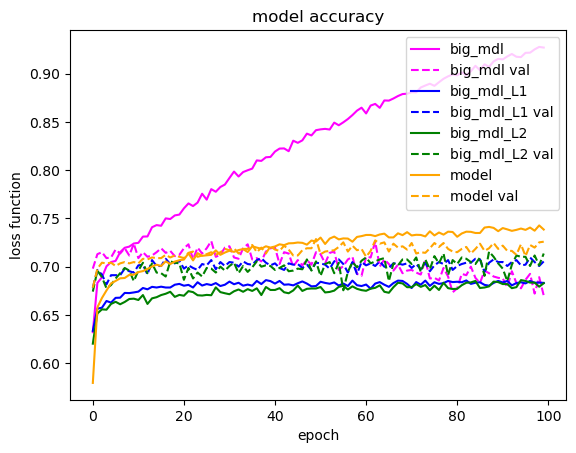

In [118]:
# big model vs smaller model
cols = ["magenta","blue","green","orange"]
labels = ['big_mdl','big_mdl_L1','big_mdl_L2', 'model']
for i,mod in enumerate([history_big_mdl, history_big_mdl_L1, history_big_mdl_L2, history_mdl]):
    plt.plot(mod.history["accuracy"],color=cols[i],label=labels[i])
    plt.plot(mod.history["val_accuracy"],color=cols[i],label="{} val".format(labels[i]),linestyle='dashed')
plt.title('model accuracy')
plt.ylabel('loss function')
plt.xlabel('epoch')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

In [119]:
# Compute accuracies
print("model")
print("Accuracy: {:.1f}% (train)".format(model.evaluate(x_train, y_train, verbose=False)[1] * 100.))
print("Accuracy: {:.1f}% (test)" .format(model.evaluate(x_test,  y_test,  verbose=False)[1] * 100.))
print("bigmodel")
print("Accuracy: {:.1f}% (train)".format(big_mdl.evaluate(x_train, y_train, verbose=False)[1] * 100.))
print("Accuracy: {:.1f}% (test)" .format(big_mdl.evaluate(x_test,  y_test,  verbose=False)[1] * 100.))
print("bigmodel L1")
print("Accuracy: {:.1f}% (train)".format(big_mdl_L1.evaluate(x_train, y_train, verbose=False)[1] * 100.))
print("Accuracy: {:.1f}% (test)" .format(big_mdl_L1.evaluate(x_test,  y_test,  verbose=False)[1] * 100.))
print("bigmodel L2")
print("Accuracy: {:.1f}% (train)".format(big_mdl_L2.evaluate(x_train, y_train, verbose=False)[1] * 100.))
print("Accuracy: {:.1f}% (test)" .format(big_mdl_L2.evaluate(x_test,  y_test,  verbose=False)[1] * 100.))

model
Accuracy: 73.7% (train)
Accuracy: 69.6% (test)
bigmodel
Accuracy: 87.6% (train)
Accuracy: 66.3% (test)
bigmodel L1
Accuracy: 69.0% (train)
Accuracy: 68.6% (test)
bigmodel L2
Accuracy: 69.1% (train)
Accuracy: 69.3% (test)


Big model overfitting but introducing the regularisation term can avoid the overfitting (shows similar accuracy to smaller model). Can also use dropout regularisation method to avoid overfitting 